In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,RepeatedKFold,train_test_split
from sklearn.metrics import precision_score,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn import tree

In [ ]:
df = pd.read_csv('/content/water_potability.csv')

In [ ]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# veri setimizin istatistiksel açıklama bilgisi
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
# veri çerçevesindeki her sütunun veri tipini, veri tiplerinin sayısal dağılımını, bellek kullanımını, eksik değerleri ve sütunların ve satırların toplamda kaç olduğu bilgisini gösterir.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
d = df["Potability"].value_counts().reset_index()
d.columns = ['Potability', 'count']

# Etiketleri insan okunabilir hale getir
d['Potability'] = d['Potability'].map({0: 'Not Potable', 1: 'Potable'})

fig = px.pie(
    d,
    values='count',
    names='Potability',
    hole=0.4,
    opacity=0.8,
    labels={"Potability": "Potability", "count": "Number of Samples"}
)
fig.update_layout(title=dict(text="Pie chart of Potability Feature"))
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()



In [ ]:
#DATALARIN KORELASYONUNA BAKMAYA YARAR
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


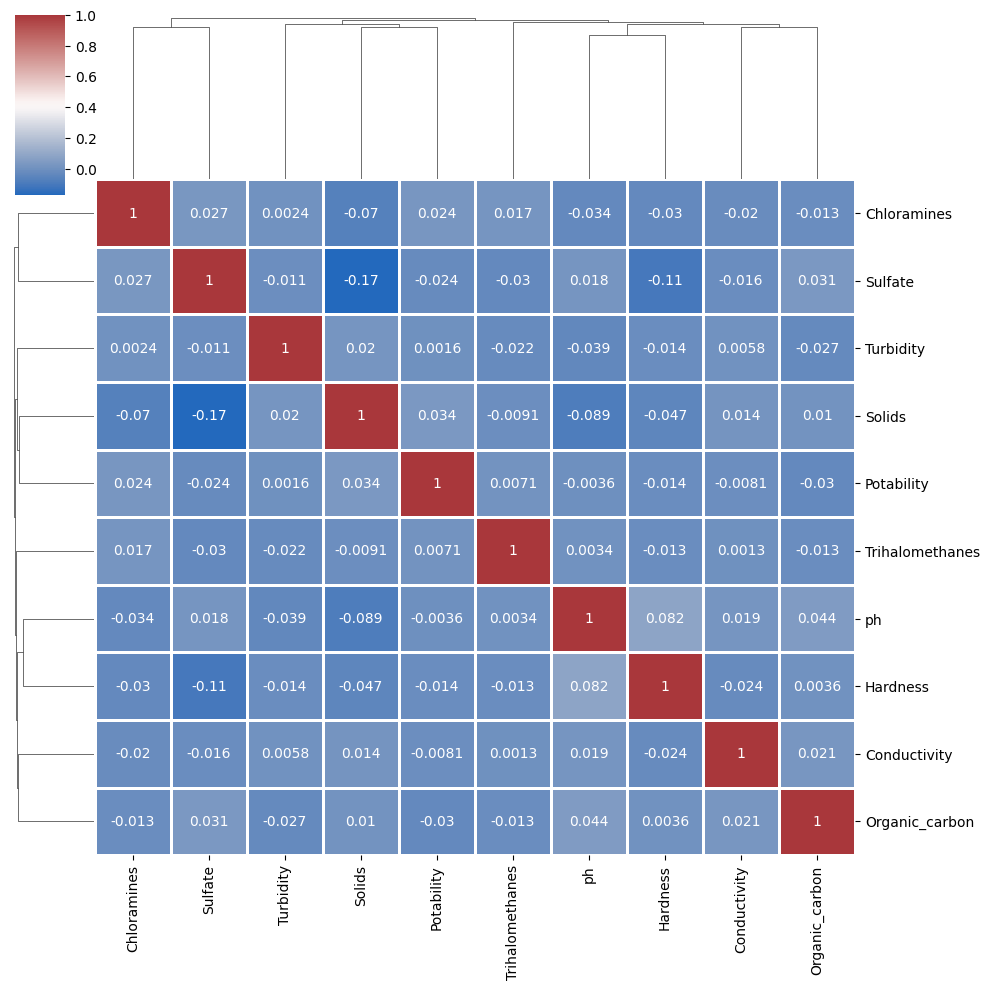

In [ ]:
sns.clustermap(df.corr(),cmap="vlag",dendrogram_ratio=(0.1,0.2), annot=True, linewidths=.8 , figsize=(10,10))
plt.show()

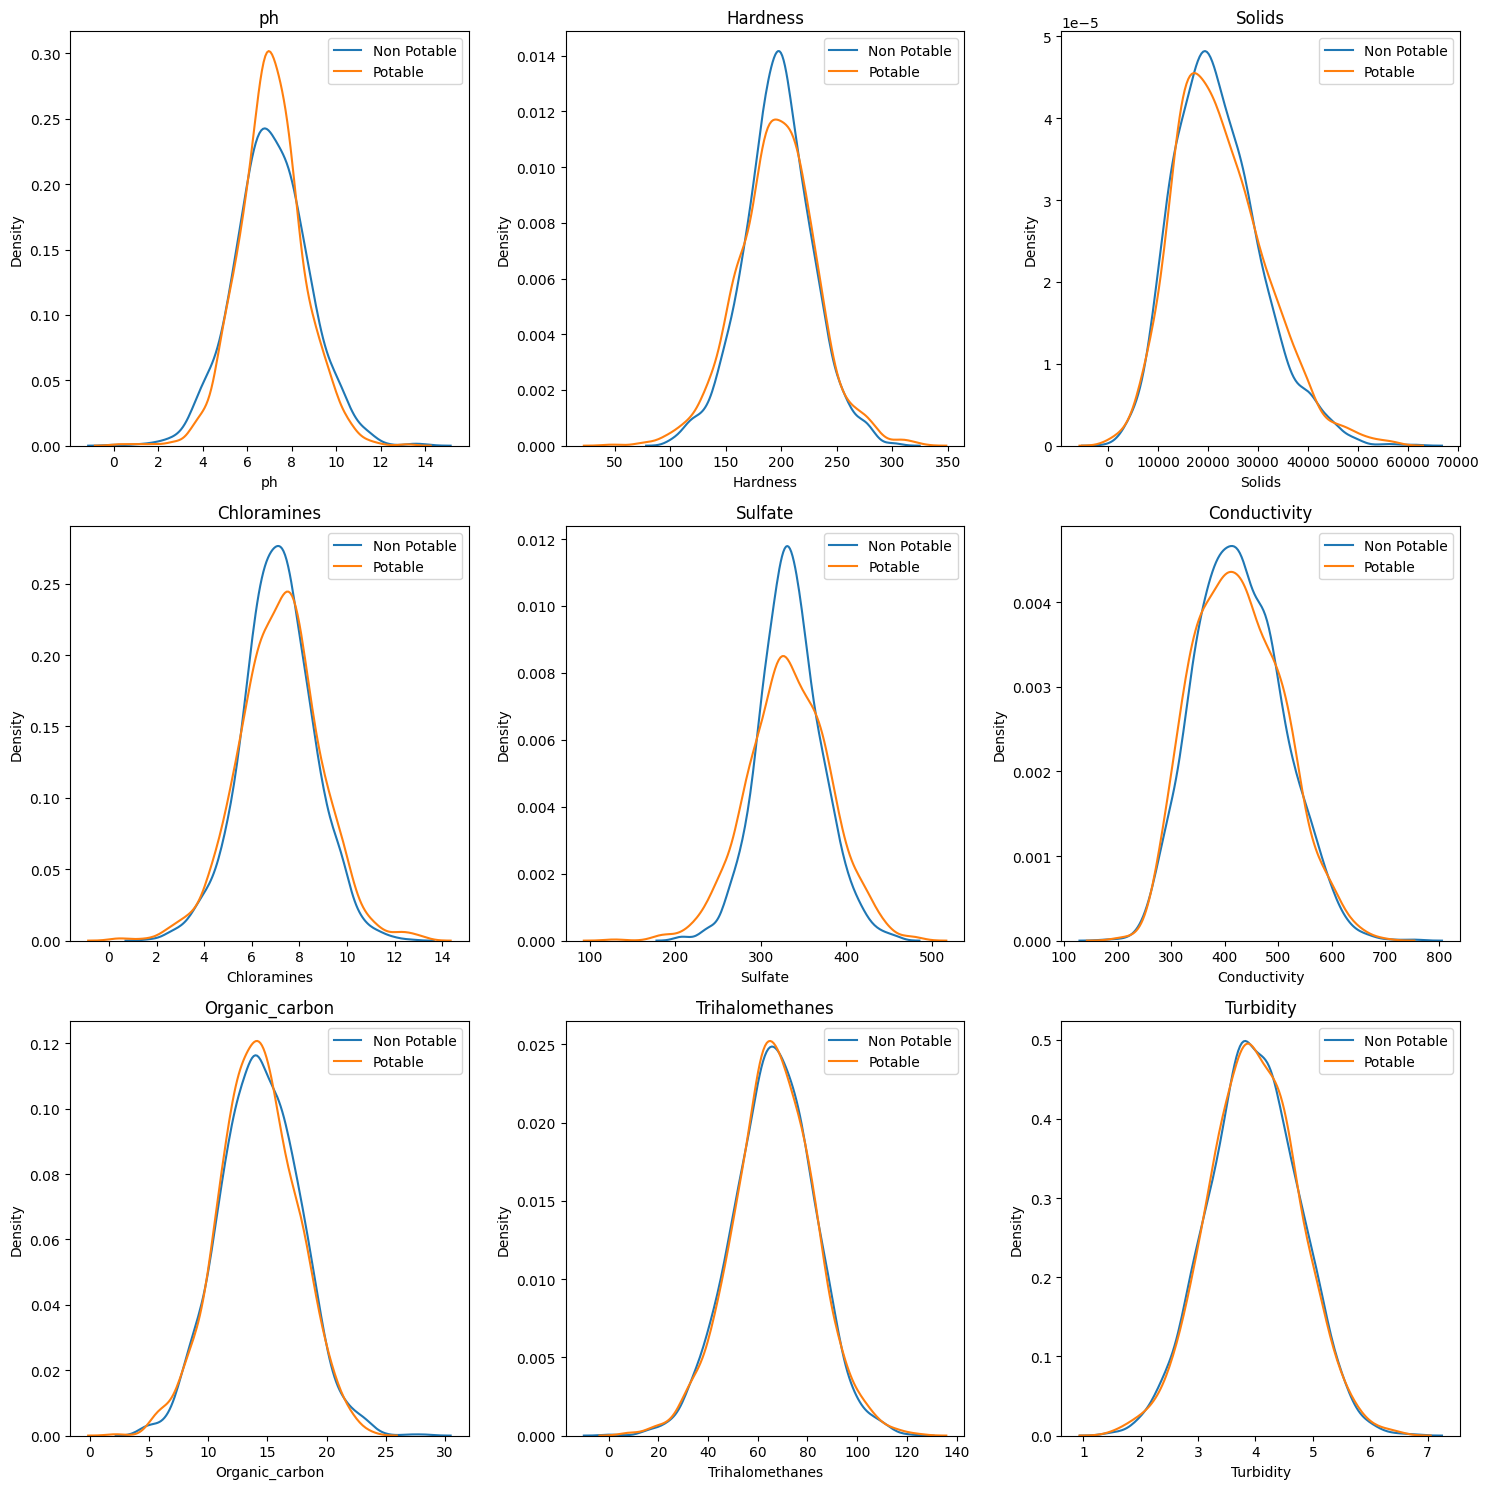

In [ ]:
#ÖZELLİK DAĞILIMI
non_potable=df.query('Potability==0')
potable=df.query('Potability==1')

plt.figure(figsize=(15,15))
for ax, col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(col)
    sns.kdeplot(x=non_potable[col],label='Non Potable')
    sns.kdeplot(x=potable[col],label='Potable')
    plt.legend()

plt.tight_layout()
plt.show()


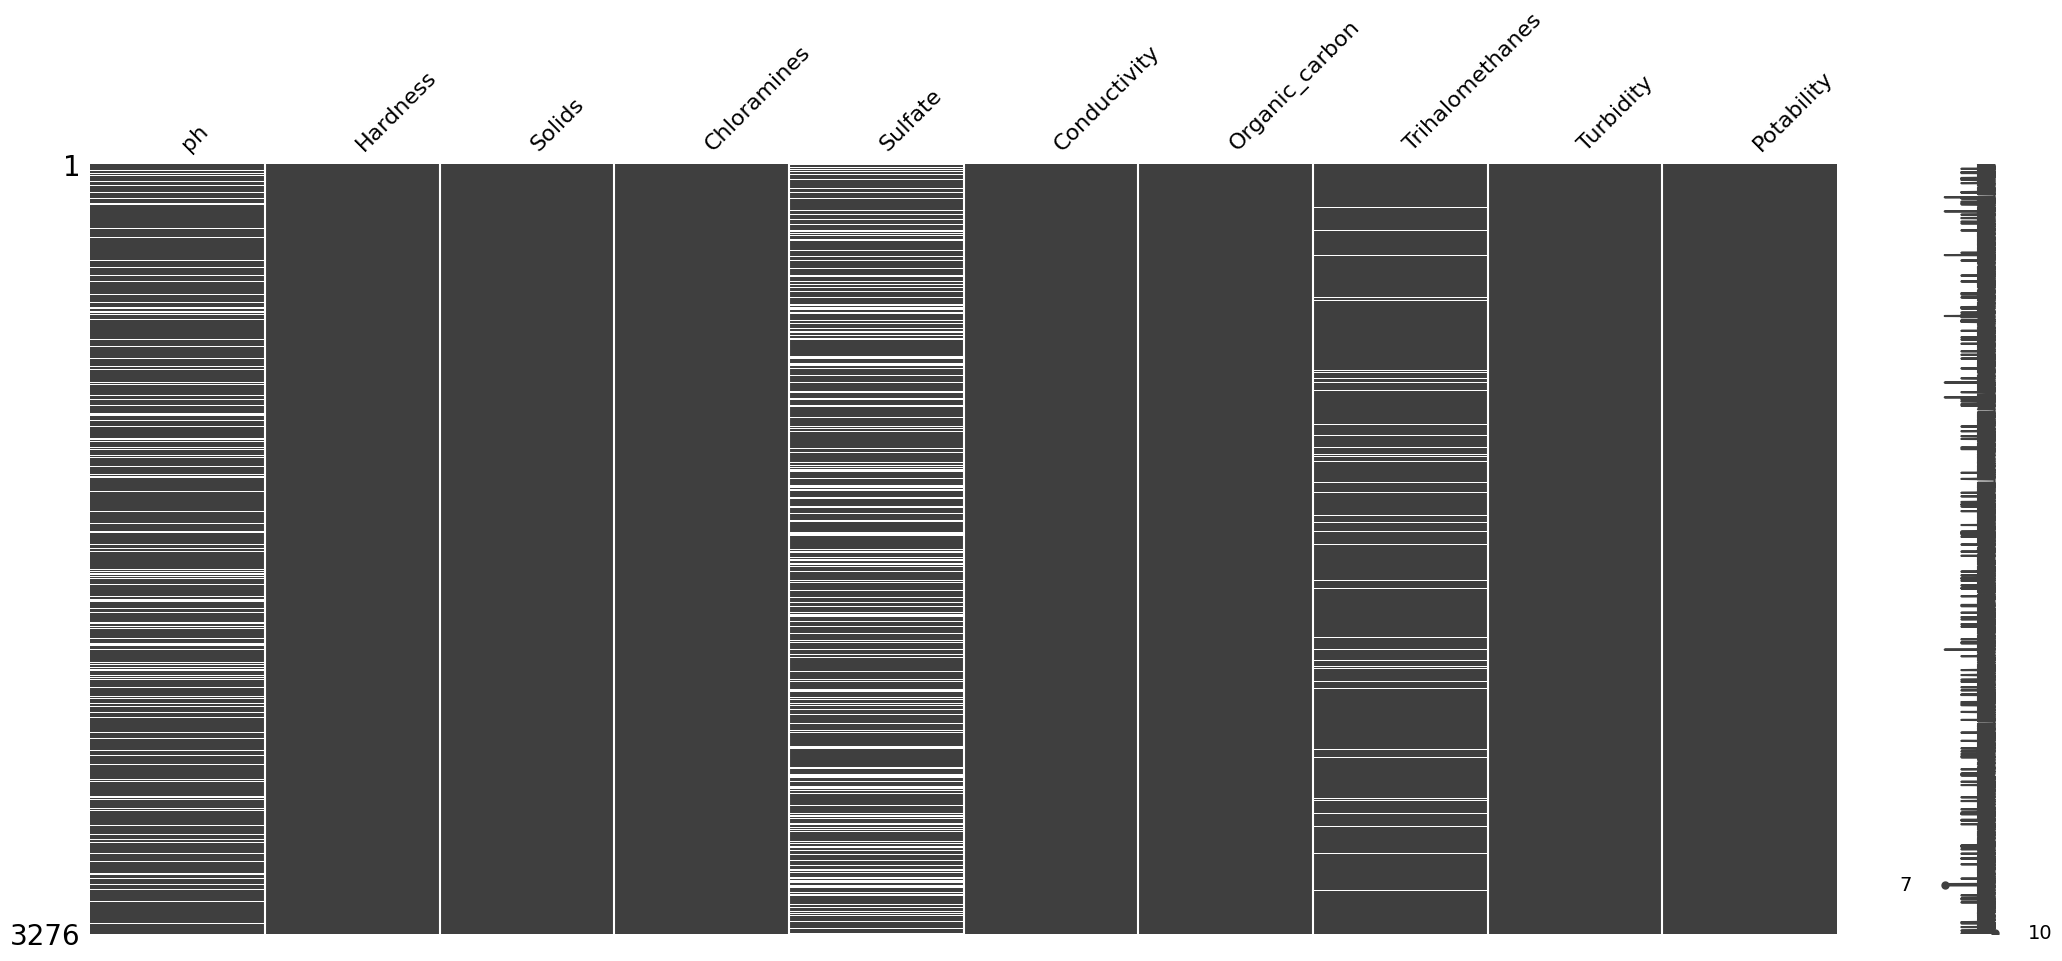

In [ ]:
#EKSİK VERİ SORUNU
msno.matrix(df)
plt.show()

In [ ]:
df.isnull().sum()

,0
ph,491
Hardness,0
Solids,0
Chloramines,0
Sulfate,781
Conductivity,0
Organic_carbon,0
Trihalomethanes,162
Turbidity,0
Potability,0


In [ ]:
df["ph"].fillna(value = df["ph"].mean(),inplace=True)
df["Sulfate"].fillna(value= df["Sulfate"].mean(),inplace=True)
df["Trihalomethanes"].fillna(value= df["Trihalomethanes"].mean(),inplace=True)

<ipython-input-59-2771e0e1992f>:1: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-59-2771e0e1992f>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

In [ ]:
df.isnull().sum()

,0
ph,0
Hardness,0
Solids,0
Chloramines,0
Sulfate,0
Conductivity,0
Organic_carbon,0
Trihalomethanes,0
Turbidity,0
Potability,0


In [ ]:
X = df.drop("Potability",axis=1).values
y = df["Potability"].values

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=3)
print("X_train",X_train.shape)
print("X_test",X_test.shape)
print("y_train",y_train.shape)
print("y_test",y_test.shape)

X_train (2293, 9)
X_test (983, 9)
y_train (2293,)
y_test (983,)


In [ ]:
X_train_max = np.max(X_train)
X_train_min = np.min(X_train)
X_train = (X_train - X_train_min)/(X_train_max - X_train_min)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min)

In [ ]:
models = [("DCT",DecisionTreeClassifier(max_depth=3)),
          ("RF",RandomForestClassifier())]

In [ ]:
fineResult = []
cmList = []
for name, model in models:
  model.fit(X_train,y_train)
  models_result= model.predict(X_test)
  score = precision_score(y_test,models_result)
  cm = confusion_matrix(y_test,models_result)
  fineResult.append((name,score))
  cmList.append((name,cm))

fineResult


[('DCT', 0.5652173913043478), ('RF', 0.6456310679611651)]

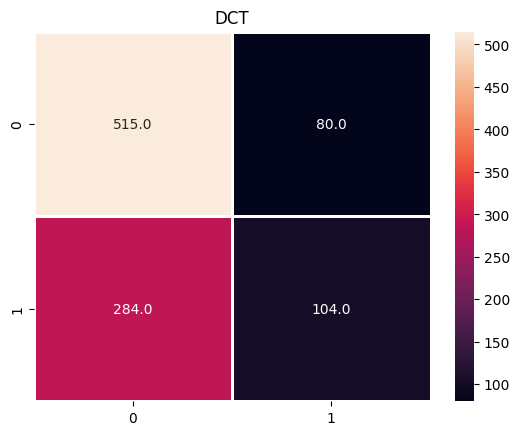

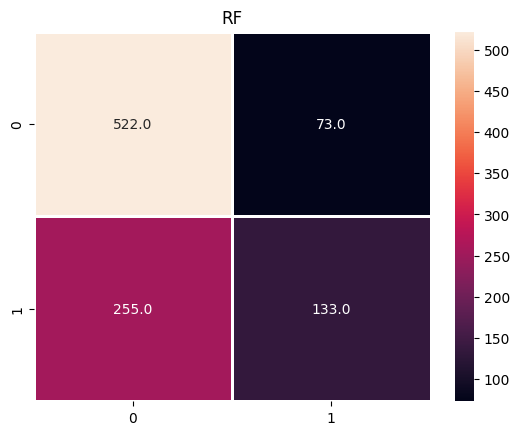

In [ ]:
for name, i in cmList:
  plt.figure()
  sns.heatmap(i, annot=True,linewidths=0.8, fmt=".1f")
  plt.title(name)
  plt.show()


In [ ]:
dt_clf = models[0][1]
dt_clf

DecisionTreeClassifier(max_depth=3)

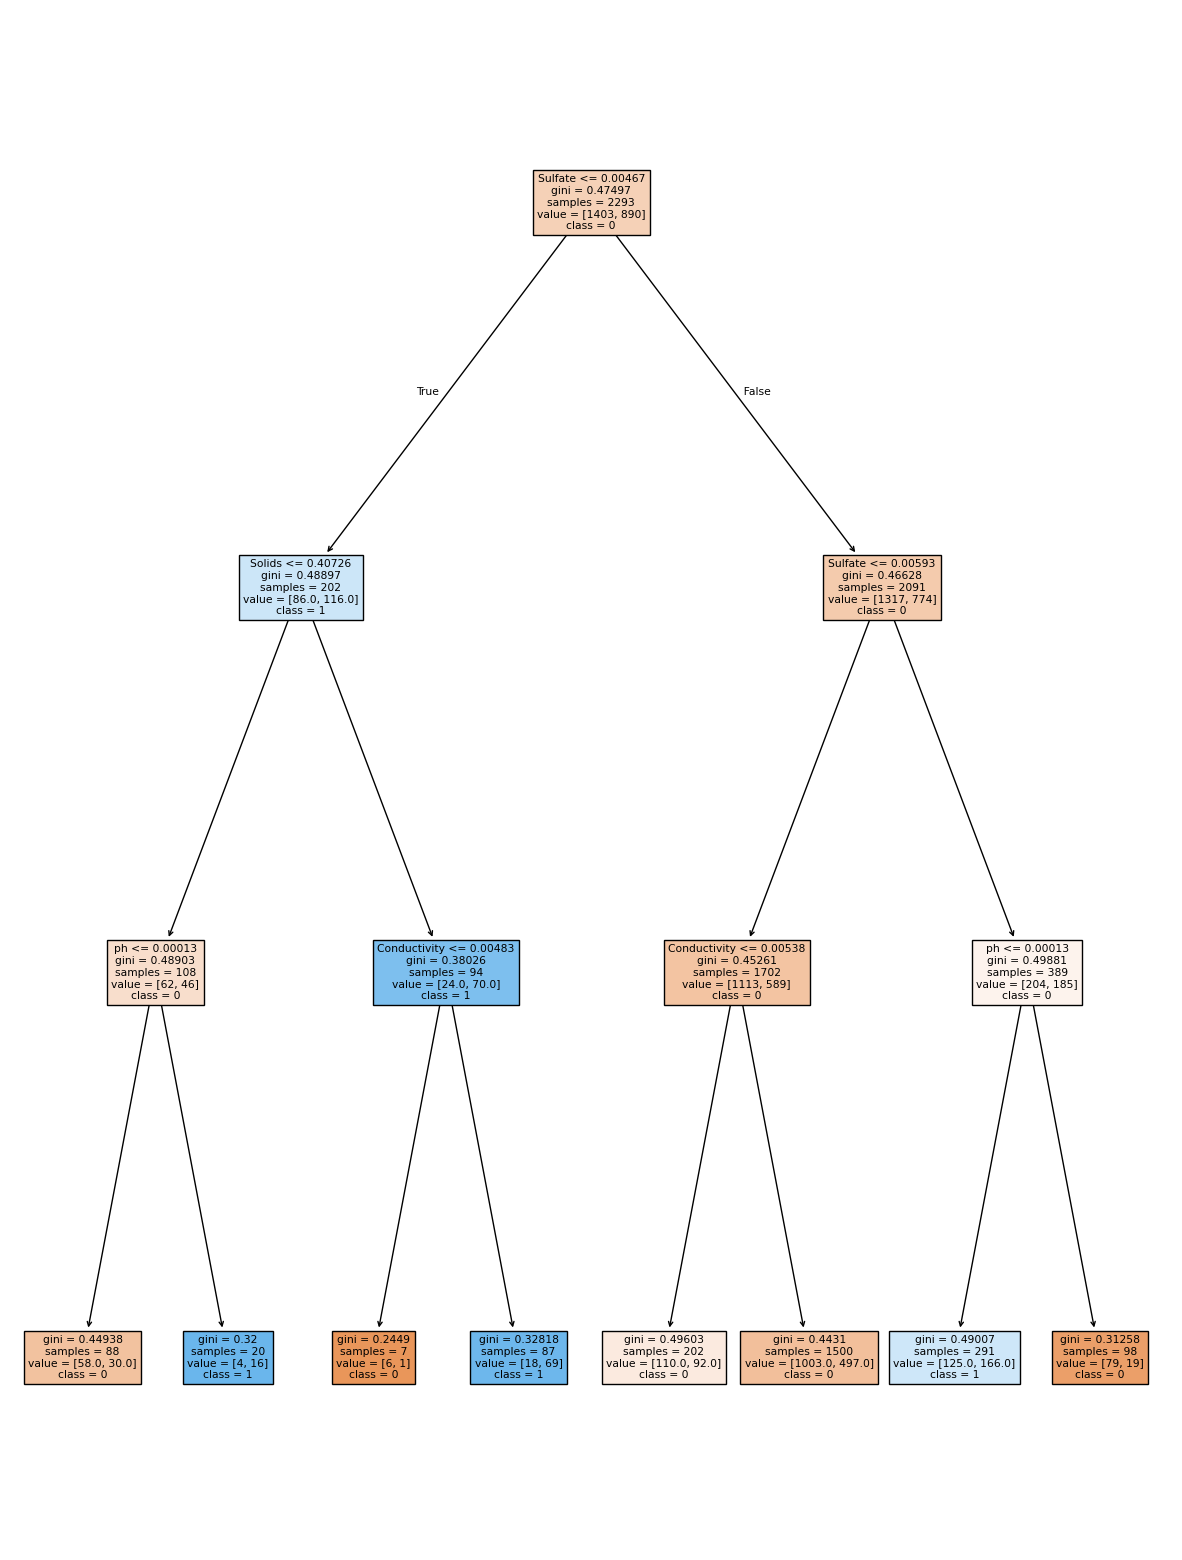

In [ ]:
plt.figure(figsize=(15,20))
tree.plot_tree(dt_clf,
               feature_names=df.columns.tolist()[:-1],
               class_names=["0","1" ],
               filled=True,
               precision=5)
plt.show()

In [ ]:
#RASTGELE ORMANLAR HİPERPARAMETRE OPTİMİZASYONU
model_params = {
    "Random Forest":
    {
        "model": RandomForestClassifier(),
        "params":
         {
            "n_estimators": [10,50,100],
            "max_features":["auto","sqrt","log2"],
            "max_depth":list(range(1,15,3))
         }
    }
}
model_params

{'Random Forest': {'model': RandomForestClassifier(),
  'params': {'n_estimators': [10, 50, 100],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth': [1, 4, 7, 10, 13]}}}

In [ ]:
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 2)
scores = []
for model_name, params in model_params.items():
  rs = RandomizedSearchCV(params["model"],params["params"],cv=cv, n_iter=10)
  rs.fit(X,y)
  scores.append([model_name, dict(rs.best_params_), rs.best_score_])
scores

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning:


10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils

[['Random Forest',
  {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10},
  np.float64(0.6617794637870043)]]